Notes on the 170302 runs

- LR set too low for rmsprop. setting higher
- gamma set too high it seems. saw no effect... high gamma requires tons of training steps i think...
- saw no effect of lr_inv... possibly set too high. 

rerunning all sims with better LR.

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import sys
import pickle
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import targprop.datasets as ds

# process the hyperparameter run

In [86]:
RUN = '../saves/170302_cl_tanh/'

In [87]:
# process directory information
data_files = [i for i in os.listdir(RUN) if i.endswith('.pickle') and 'params' not in i]
sim_nums = [i.replace('.pickle', '') for i in data_files]
param_files = [i+'params.pickle' for i in sim_nums]
assert len(data_files) == len(param_files)

total_sims = len(data_files)
print 'total sims: ', total_sims

total sims:  500


In [88]:
# start with the first file
data = pickle.load(open(RUN+data_files[0], 'rb'))
params = pickle.load(open(RUN+param_files[0], 'rb'))

err_algs = len(data)

In [89]:
# make each value a list entry
for i,j in params.items():
  params[i] = [j]
for k in range(err_algs):
  for i,j in data[k].items():
    data[k][i] = [j]

In [90]:
# now go through the rest
for i in range(1, total_sims):
  data_ = pickle.load(open(RUN+data_files[i], 'rb'))
  params_ = pickle.load(open(RUN+param_files[i], 'rb'))
  for i,j in params_.items():
    params[i].append(j)
  for k in range(err_algs):
    for i,j in data_[k].items():
      data[k][i].append(j)

In [91]:
for k in range(err_algs):
  for i in data[k].keys():
    data[k][i+str(k)] = data[k].pop(i)

In [92]:
df = pd.DataFrame(params)
for k in range(err_algs):
  df = df.join(pd.DataFrame(data[k]))

In [93]:
mnist = ds.mnist_data_test()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# downselect...

In [94]:
#df = df[df.L_test1 < 2.0]

In [95]:
# l_bool = df.shape[0]*[None]
# for i in range(df.shape[0]):
#   l_bool[i] = df.l_dim[i] == [200, 100, 5, 100, 200]
# df = df[l_bool]

# plot

In [96]:
def giant_regplot(df, cols=None, rows=None, logs=[]):

  if not cols:
    cols = df.columns
    for col in cols:
      try:
        if len(df[col].unique())==1: # this returns an error when df[col] is an e.g. list
          df = df.drop(col, axis=1) # drop columns with all identical entries
      except:
        df = df.drop(col, axis=1) # if above returned an error, drop
    cols = df.columns # now we have our column set
  if not rows:
    rows = df.columns
  
  isnumeric_col = [np.any([isinstance(i, (int, long, float, complex)) for i in df[c]]) for c in cols]  
  isnumeric_row = [np.any([isinstance(i, (int, long, float, complex)) for i in df[r]]) for r in rows]  
  
  fact = 3
  num_cols, num_rows = len(cols), len(rows)
  f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols, fact*num_rows), sharey=False, sharex=False)
  for ir, row in enumerate(rows):
    for ic, col,  in enumerate(cols):
      logx_bool = col in logs
      if logx_bool:
        ax[ir, ic].set_xscale('log', basex=10)
      logy_bool = row in logs
      if logy_bool:
        ax[ir, ic].set_yscale('log', basex=10)

      if np.logical_xor(isnumeric_row[ir], isnumeric_col[ic]):
        sns.violinplot(x=col, y=row, data=df, ax=ax[ir, ic])
      elif (isnumeric_row[ir] and isnumeric_col[ic]):
        sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
        #ax[ir, ic].scatter(df[col], df[row], c=df['activation']=='tanh')
        d_range = df[row].max() - df[row].min()
        ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
        ax[ir, ic].set_xlim([df[col].min(), df[col].max()])

      if ir < num_rows-1:
        ax[ir, ic].xaxis.label.set_visible(False)
      if ic > 0:
        ax[ir, ic].yaxis.label.set_visible(False)
        
  return f, ax


# giant hyperparameter plot

In [97]:
logs=['gamma', 'learning_rate', 'learning_rate_inv', 'noise_str', 'learning_rate_rinv']

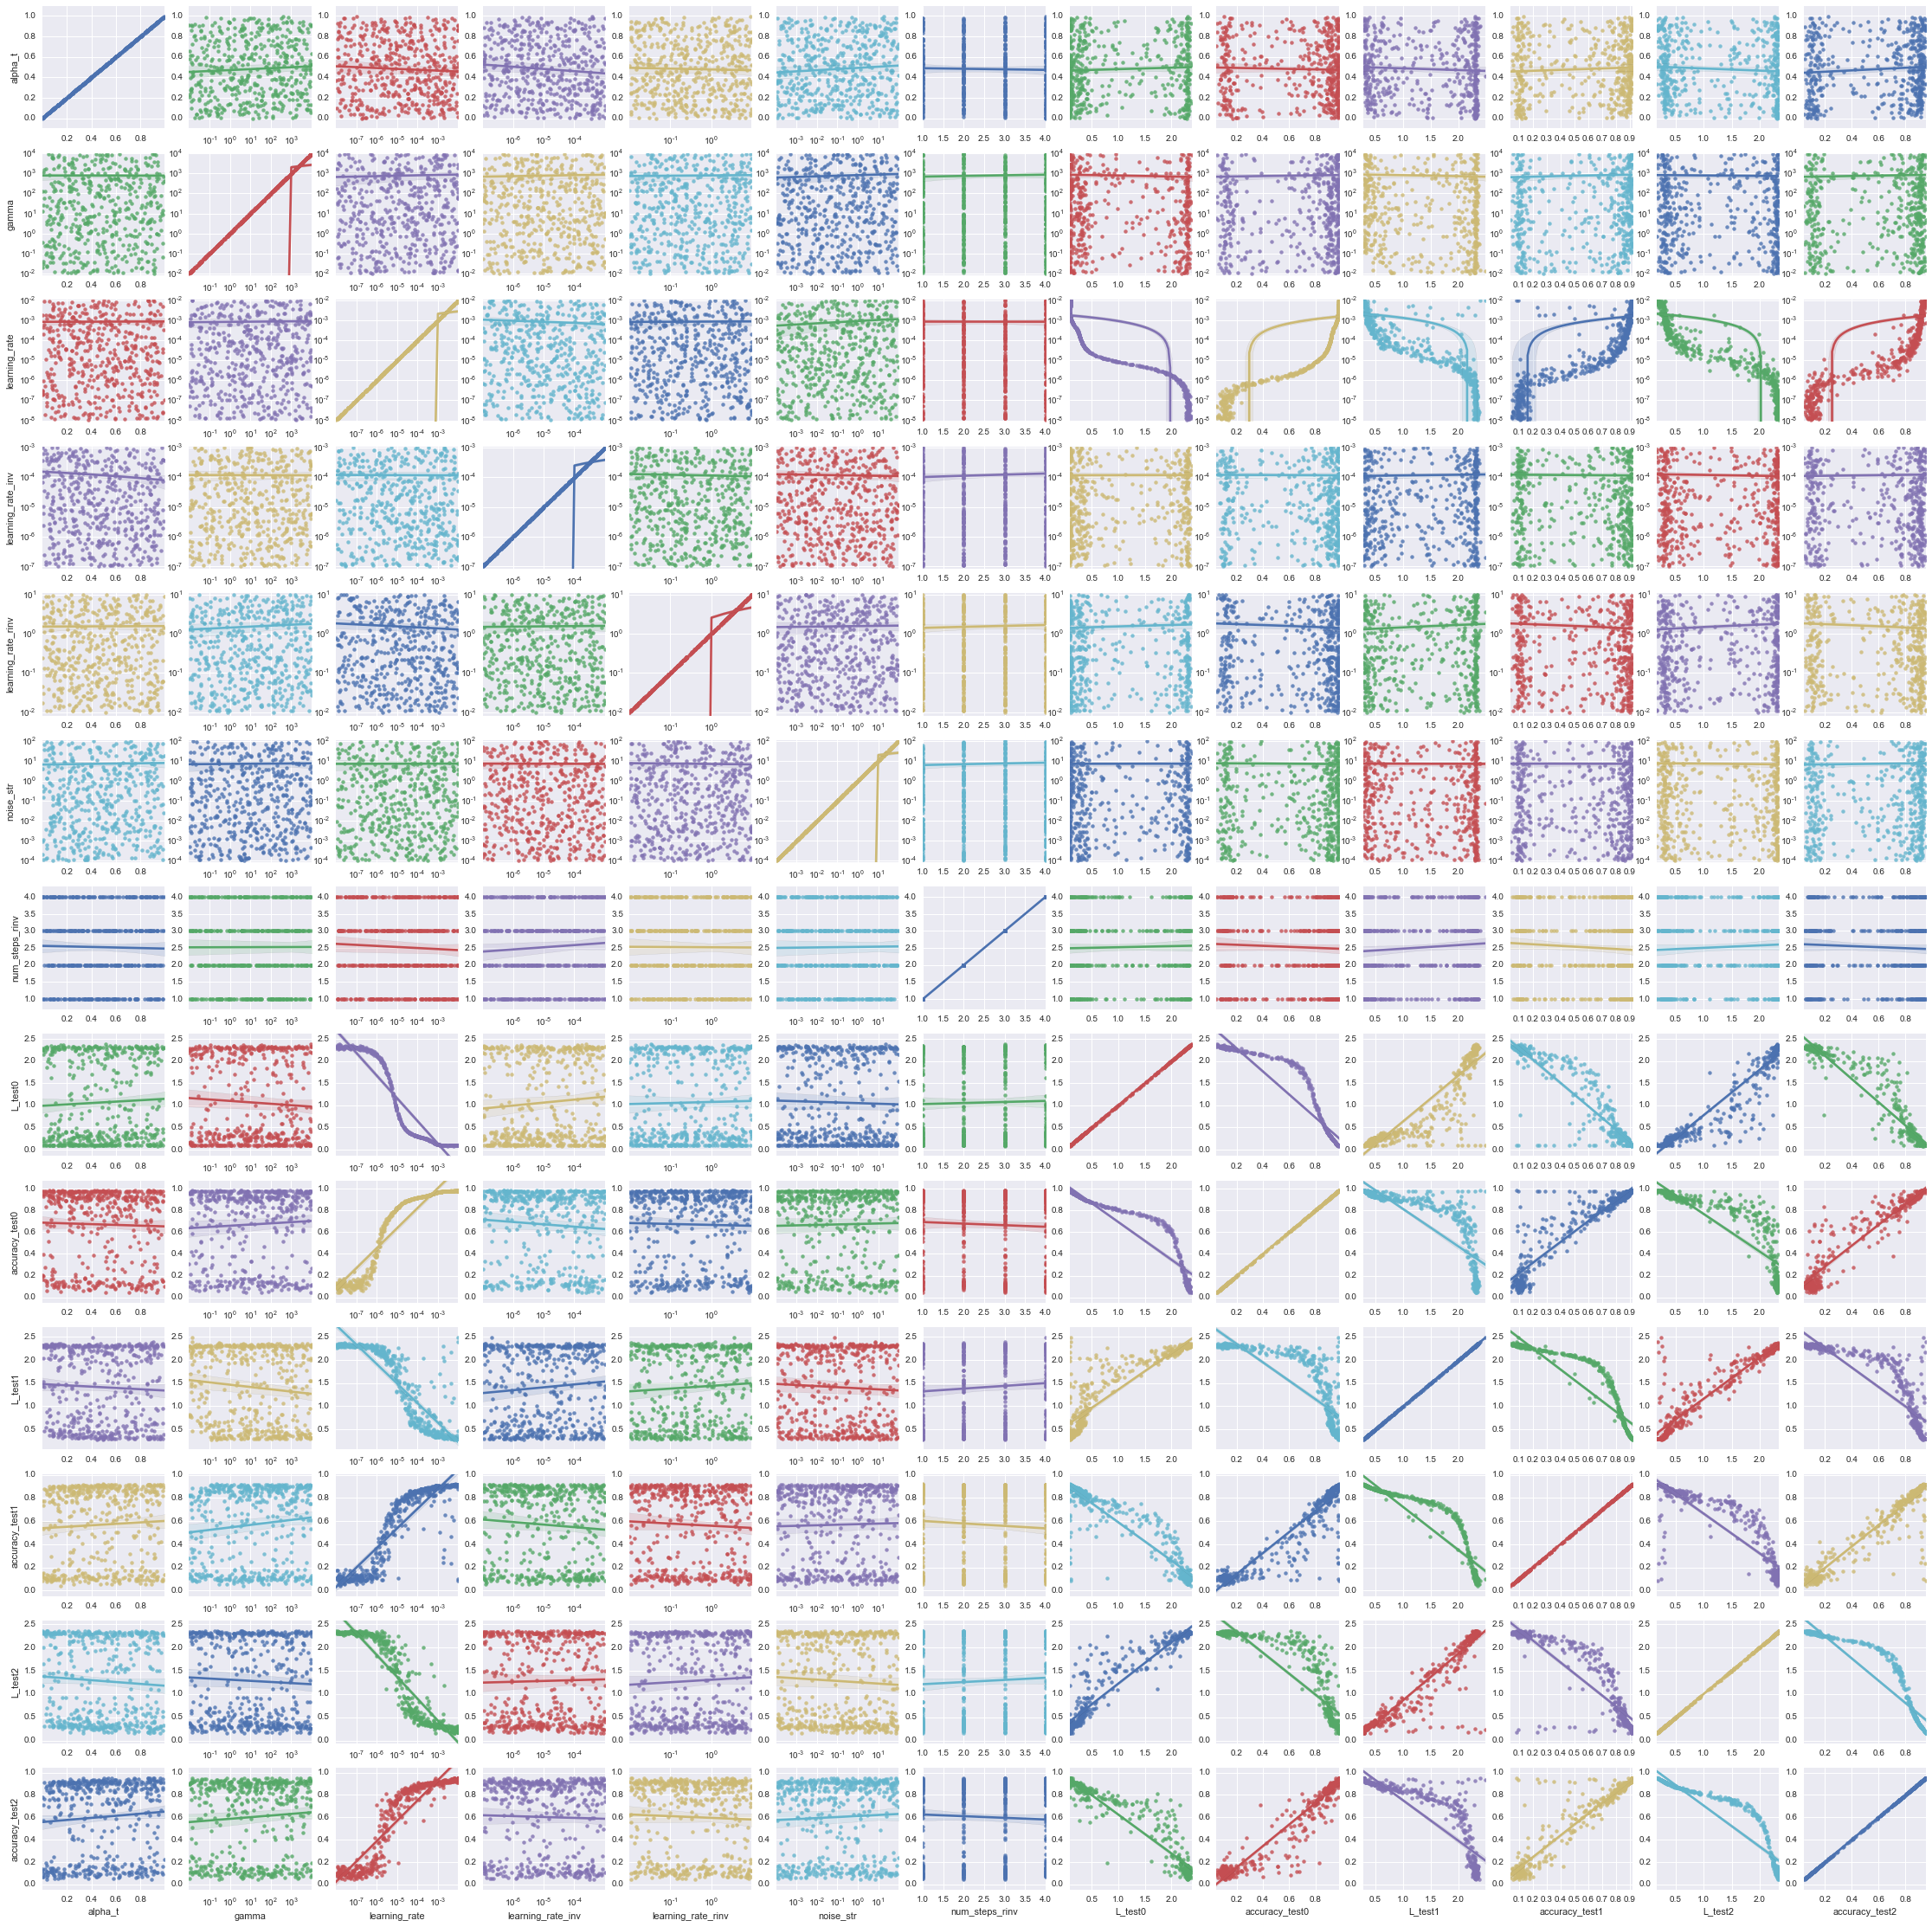

In [98]:
giant_regplot(df, logs=logs)
plt.show()

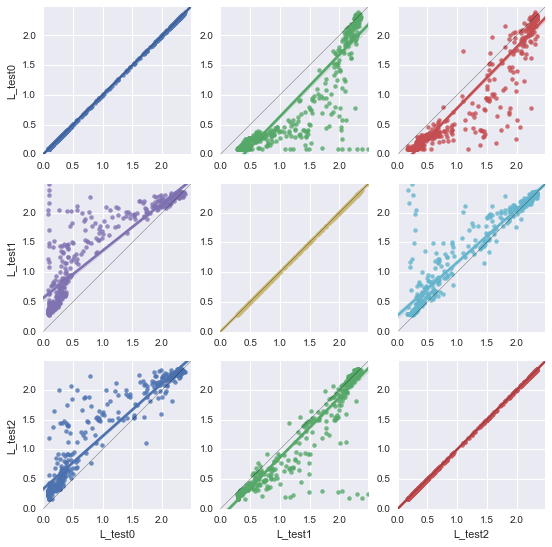

In [99]:
cols=['L_test0', 'L_test1', 'L_test2']
f, ax = giant_regplot(df, cols=cols, rows=cols, logs=logs)
limit = df[cols].max().max()
for axis in ax.flatten():
  axis.set_xlim([0, limit])
  axis.set_ylim([0, limit])
  axis.plot([0, limit],[0, limit], 'k', linewidth=0.5, alpha=0.5)
plt.show()

# autoencoder


In [100]:
ind0 = df['L_test0'].argmin()
ind1 = df['L_test1'].argmin()
ind2 = df['L_test2'].argmin()

In [101]:
print df['L_test0'][ind0], df['accuracy_test0'][ind0]
print df['L_test1'][ind1], df['accuracy_test1'][ind1]
print df['L_test2'][ind2], df['accuracy_test2'][ind2]



0.0844013988972 0.980000019073
0.284444898367 0.918200016022
0.16232842207 0.950200021267


In [49]:
df.columns

Index([u'SGD', u'activation', u'alpha_t', u'batch_size', u'dataset', u'gamma',
       u'l_dim', u'learning_rate', u'learning_rate_inv', u'learning_rate_rinv',
       u'mode', u'noise_str', u'num_steps_rinv', u'preprocess', u't_steps',
       u'top_loss', u'L_test0', u'accuracy_test0', u'reconstruction0',
       u'L_test1', u'accuracy_test1', u'reconstruction1', u'L_test2',
       u'accuracy_test2', u'reconstruction2'],
      dtype='object')

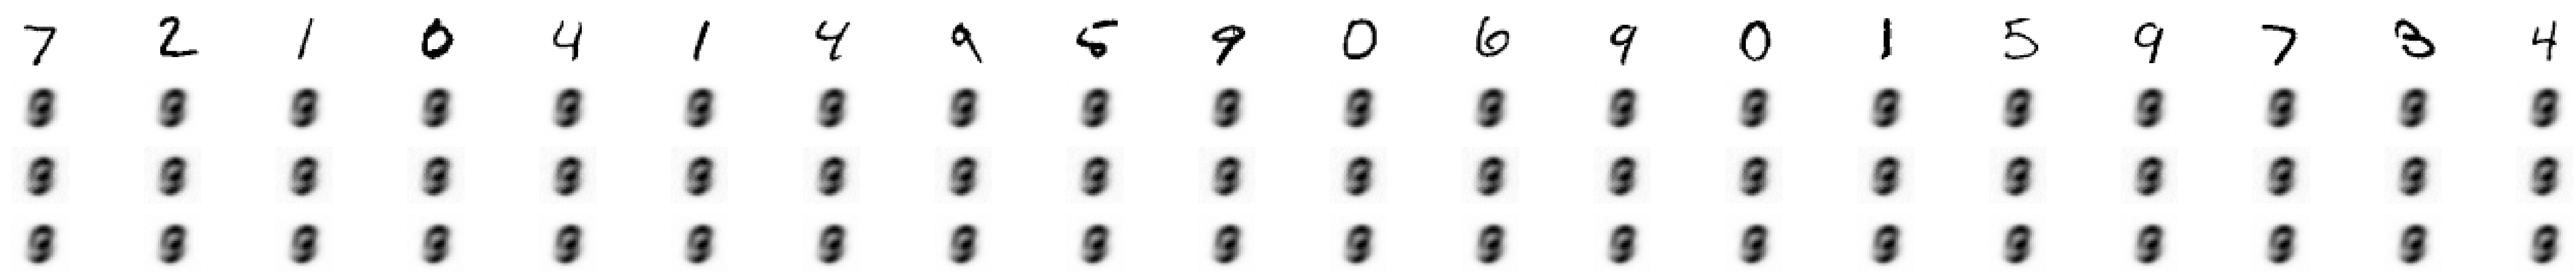

In [50]:
n = 20
f, ax = plt.subplots(4, n, figsize=(5*n,5*2))
for col, i in enumerate(range(n)):
  example = i
  ax[0, col].matshow(mnist.inputs[example].reshape((28,28)))
  ax[1, col].matshow(df['reconstruction0'][ind0][example].reshape((28,28)))
  ax[2, col].matshow(df['reconstruction1'][ind1][example].reshape((28,28)))
  ax[3, col].matshow(df['reconstruction2'][ind2][example].reshape((28,28)))
  ax[0, col].axis('off')
  ax[1, col].axis('off')
  ax[2, col].axis('off')
  ax[3, col].axis('off')
plt.show()
